In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np

In [2]:
# Setting the EnergyPlus IDF file name
filename='double_glaze.idf'

# Setting the corresponding weather file
epw_file='Torino_IT-hour.epw'

# Loading the EnergyPlus building model from the IDF file
building = ef.get_building(filename)

In [3]:
# Extracting the names of all materials defined in the IDF file
materials_list = [materials.Name for materials in building.idfobjects["MATERIAL"]]
print(materials_list)

['Gypsum Plastering_.02', 'Brick_.2', 'Masonry - mediumweight Dry_.2', 'Mortar_.03', 'Ceramic/porcelain_.01', 'Cement/plaster/mortar - cement plaster_.015', 'Masonry - heavyweight Dry_.5', 'Gypsum Plastering_.015', 'Painted Oak_.035', 'EPS Expanded Polystyrene (Heavyweight)_.001', 'Brickwork Outer_.1', 'XPS Extruded Polystyrene  - CO2 Blowing_.0795', 'Concrete Block (Medium)_.1', 'Gypsum Plastering_.013']


In [4]:
# Selecting all constructions defined in the IDF file
cons = building.idfobjects["CONSTRUCTION"]
print(cons)

[
Construction,
    LinearBridgingConstruction,    !- Name
    LinearBridgingLayer;      !- Outside Layer
, 
Construction,
    IRTSurface,               !- Name
    IRTMaterial;              !- Outside Layer
, 
Construction,
    internal floor 46cm,      !- Name
    Gypsum Plastering_.02,    !- Outside Layer
    Brick_.2,                 !- Layer 2
    Masonry - mediumweight Dry_.2,    !- Layer 3
    Mortar_.03,               !- Layer 4
    Ceramic/porcelain_.01;    !- Layer 5
, 
Construction,
    internal floor 46cm_Rev,    !- Name
    Ceramic/porcelain_.01,    !- Outside Layer
    Mortar_.03,               !- Layer 2
    Masonry - mediumweight Dry_.2,    !- Layer 3
    Brick_.2,                 !- Layer 4
    Gypsum Plastering_.02;    !- Layer 5
, 
Construction,
    internal floor 46cm_Reversed,    !- Name
    Ceramic/porcelain_.01,    !- Outside Layer
    Mortar_.03,               !- Layer 2
    Masonry - mediumweight Dry_.2,    !- Layer 3
    Brick_.2,                 !- Layer 4
  

In [5]:
# Selecting all detailed building surfaces defined in the IDF file
surfaces = building.idfobjects['BUILDINGSURFACE:DETAILED']

# Extracting the names of all surfaces
s_names = [surface.Name for surface in surfaces] 

# Isolating vertical outdoor walls with a tilt of 90 degrees
vertical_walls = [sf for sf in surfaces if (sf.tilt == 90.0 and sf.Outside_Boundary_Condition=='Outdoors')]

print ([sf.Construction_Name for sf in vertical_walls])

['Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm', 'Copy of Uninsulated Wall 53cm']


In [6]:
# Identifying constructions that are used for vertical outdoor walls
con_change = [con for con in cons if con.Name in [sf.Construction_Name for sf in vertical_walls]]
print(con_change)

[
Construction,
    Copy of Uninsulated Wall 53cm,    !- Name
    Cement/plaster/mortar - cement plaster_.015,    !- Outside Layer
    XPS Extruded Polystyrene  - CO2 Blowing_.0795,    !- Layer 2
    Masonry - heavyweight Dry_.5,    !- Layer 3
    Gypsum Plastering_.015;    !- Layer 4
]


In [7]:
# Selecting the materials of the walls, excluding the construction name
mat_select = [mat.fieldvalues[2:] for mat in con_change] #select the materials of the wall; starting from the second element as the first is the name 
print(mat_select)

[['Cement/plaster/mortar - cement plaster_.015', 'XPS Extruded Polystyrene  - CO2 Blowing_.0795', 'Masonry - heavyweight Dry_.5', 'Gypsum Plastering_.015']]


In [8]:
# Identifying the materials used in the selected constructions
mat_change = [mat for mat in materials_list for i in mat_select if mat in i]
print(mat_change)

['Cement/plaster/mortar - cement plaster_.015', 'Masonry - heavyweight Dry_.5', 'Gypsum Plastering_.015', 'XPS Extruded Polystyrene  - CO2 Blowing_.0795']


In [9]:
# Creating the insulation parameter
insulation = FieldSelector(class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795', field_name='Thickness')
thickness = RangeParameter(min_val = 0.01, max_val=0.35)
insulation_param = Parameter(
        selector=insulation,
        value_descriptor=thickness,
        name='Insulation Thickness'
    )

# Setting the calculation method for natural ventilation to 'AirChanges/Hour'
for natural_ventilation in building.idfobjects["ZoneVentilation:DesignFlowRate"]:
            natural_ventilation.Design_Flow_Rate_Calculation_Method='AirChanges/Hour'

# Creating the ACH (Air Changes per Hour) parameter
ventilation = FieldSelector(class_name='ZoneVentilation:DesignFlowRate', object_name='*', field_name='Air Changes per Hour')
ventilation_interval = RangeParameter(min_val = 0, max_val=6)
ventilation_param = Parameter(
        selector=ventilation,
        value_descriptor=ventilation_interval,
        name='ACH'
    )

# Creating the parameter for shading irradiation setpoint
shading_solar = FieldSelector(class_name='WindowShadingControl',object_name='*', field_name='Setpoint 2')
shading_solar_interval = RangeParameter(min_val = 80, max_val = 300)
shading_solar_param = Parameter(
        selector=shading_solar,
        value_descriptor=shading_solar_interval,
        name='Irradiation'
    )

# Creating the parameter for shading temperature setpoint
shading_temp = FieldSelector(class_name='WindowShadingControl',object_name='*', field_name='Setpoint')
shading_temp_interval = RangeParameter(min_val = 18, max_val = 28)
shading_temp_param = Parameter(
        selector=shading_temp,
        value_descriptor=shading_temp_interval,
        name='Temperature'
    )

c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:424: FutureWarning: Use value_descriptors instead of value_descriptor.
  warnings.warn(


In [10]:
# Defining the objectives for optimization
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility']

In [11]:
# Combining all optimization parameters into a list
parameters=[insulation_param] + [shading_solar_param] + [shading_temp_param] + [ventilation_param]

# Creating the optimization problem using the defined parameters and objectives
problem=EPProblem(parameters, objectives)

# Generating samples for optimization using Latin Hypercube Sampling (LHS) method
samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=100)

print(samples)

    Insulation Thickness  Irradiation  Temperature       ACH
0               0.030955   278.003566    22.065440  3.763089
1               0.223336   163.808092    18.482032  5.300292
2               0.302776   202.571487    21.585721  5.434129
3               0.245529   152.679588    23.066548  2.001185
4               0.147293   247.124922    21.284349  1.701871
..                   ...          ...          ...       ...
95              0.090733   170.319395    24.298448  3.244792
96              0.123092   223.684465    25.443654  4.767438
97              0.219633   146.420566    21.445552  2.516584
98              0.344599   112.212206    26.799928  0.889543
99              0.037437   175.268400    19.314053  5.212753

[100 rows x 4 columns]


In [12]:
# Creating an EvaluatorEP object for evaluating the optimization problem
evaluator = EvaluatorEP(problem, building, out_dir='outputdir', err_dir='outputdir',epw=epw_file)

# Applying the evaluator to the generated samples and keeping input data
outputs = evaluator.df_apply(samples, keep_input=True)

outputs.describe()

Executing:   0%|          | 0/100 [00:00<?, ?row/s]

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
count,100.000000,100.000000,100.000000,100.000000,1.000000e+02,1.000000e+02,1.000000e+02
mean,0.180043,189.983557,22.998177,2.999497,1.404396e+10,1.705942e+10,1.364365e+10
std,0.098743,63.892494,2.903004,1.740875,1.238312e+05,3.287529e+09,1.189886e+09
min,0.011021,80.454448,18.020812,0.007965,1.404392e+10,1.410875e+10,1.150508e+10
25%,0.095548,135.808793,20.488654,1.531382,1.404392e+10,1.467755e+10,1.285284e+10
50%,0.181087,189.801018,23.009161,2.997895,1.404392e+10,1.566824e+10,1.347104e+10
75%,0.263780,245.354649,25.465214,4.495814,1.404392e+10,1.850722e+10,1.460183e+10
max,0.349325,298.686633,27.981380,5.989789,1.404463e+10,2.816301e+10,1.675826e+10


In [13]:
outputs.to_csv('path_to_save/outputs.csv', index=False)
description = outputs.describe()
description.to_csv('path_to_save/description.csv', index=True)

In [14]:
outputs.to_pickle("simulation_sample_100.pkl")

<Figure size 640x480 with 0 Axes>

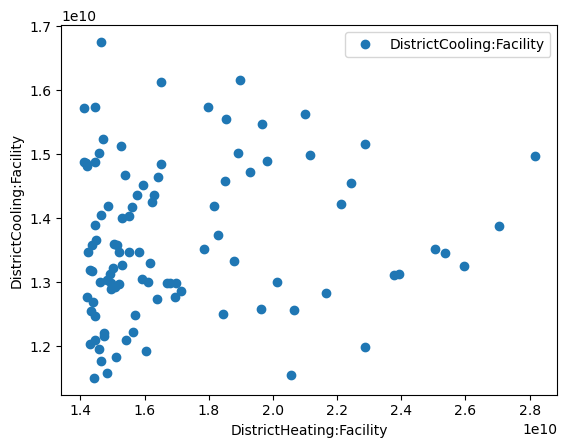

In [15]:
# Plotting the data points for district heating vs. district cooling
plt.figure()
_ = outputs.plot(x=objectives[1], y=objectives[2], style = 'o')
plt.xlabel(objectives[1])
plt.ylabel(objectives[2])
plt.savefig('heating_cooling.png', format='png', dpi=600)
plt.show()

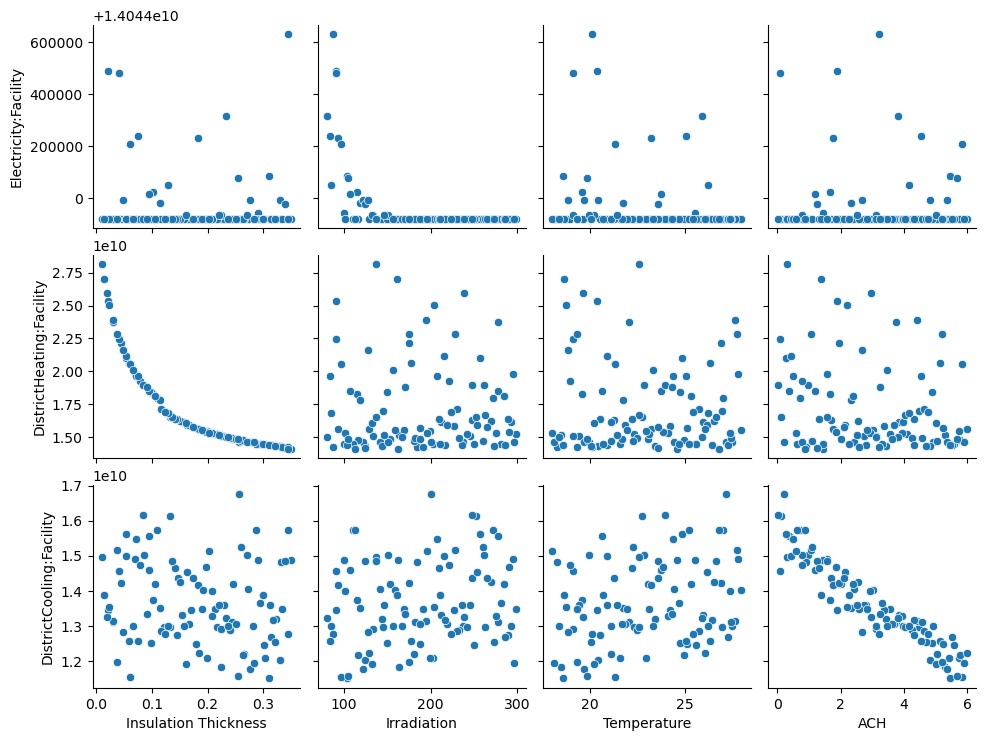

In [16]:
# Visualize the relationships between optimization parameters and objectives
_=pairplot(outputs,x_vars=samples.columns, y_vars=objectives, kind="scatter")
plt.savefig('all.png', format='png', dpi=600)

In [17]:
# Scaling the outputs for correlation calculation
outputs_corr = outputs/10e6
outputs_corr.corr().to_csv('path_to_save/outputs_corr.csv', index=True)
outputs_corr.corr()

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
Insulation Thickness,1.000000,-0.068232,-0.042107,0.230239,-0.057124,-0.877178,-0.145916
Irradiation,-0.068232,1.000000,0.076994,-0.051389,-0.515464,-0.024421,0.185848
Temperature,-0.042107,0.076994,1.000000,0.020177,-0.176315,-0.074469,0.241175
ACH,0.230239,-0.051389,0.020177,1.000000,-0.004117,-0.248758,-0.939926
Electricity:Facility,-0.057124,-0.515464,-0.176315,-0.004117,1.000000,0.134031,-0.141305
DistrictHeating:Facility,-0.877178,-0.024421,-0.074469,-0.248758,0.134031,1.000000,0.121427
DistrictCooling:Facility,-0.145916,0.185848,0.241175,-0.939926,-0.141305,0.121427,1.000000


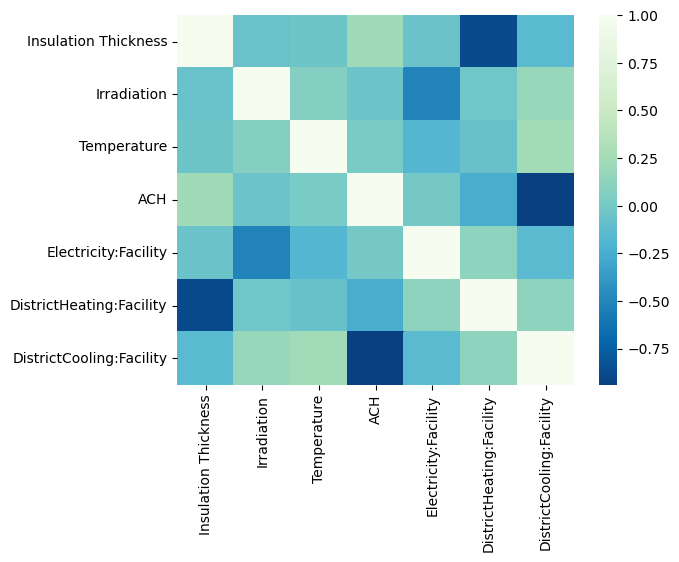

In [18]:
# Creating a heatmap to visualize the correlation matrix
_ = heatmap(outputs_corr.corr(), cmap='GnBu_r')
plt.savefig('outputs_corr.png', format='png', dpi=600, bbox_inches='tight')

In [19]:
# Creating a new DataFrame for outputs with total consumption calculated
outputs_consumption = outputs
outputs_consumption["TotConsumption"] = outputs_consumption["DistrictCooling:Facility"] + outputs_consumption["DistrictHeating:Facility"] + outputs_consumption["Electricity:Facility"]
outputs_consumption.to_csv('path_to_save/outputs_consumption.csv', index=True)
outputs_consumption

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,TotConsumption
0,0.030955,278.003566,22.065440,3.763089,1.404392e+10,2.377872e+10,1.312106e+10,5.094370e+10
1,0.223336,163.808092,18.482032,5.300292,1.404392e+10,1.512299e+10,1.183636e+10,4.100326e+10
2,0.302776,202.571487,21.585721,5.434129,1.404392e+10,1.445231e+10,1.209545e+10,4.059168e+10
3,0.245529,152.679588,23.066548,2.001185,1.404392e+10,1.485089e+10,1.419329e+10,4.308810e+10
4,0.147293,247.124922,21.284349,1.701871,1.404392e+10,1.628290e+10,1.436327e+10,4.469009e+10
...,...,...,...,...,...,...,...,...
95,0.090733,170.319395,24.298448,3.244792,1.404392e+10,1.878199e+10,1.333844e+10,4.616435e+10
96,0.123092,223.684465,25.443654,4.767438,1.404392e+10,1.693637e+10,1.276518e+10,4.374546e+10
97,0.219633,146.420566,21.445552,2.516584,1.404393e+10,1.513302e+10,1.359066e+10,4.276761e+10
98,0.344599,112.212206,26.799928,0.889543,1.404392e+10,1.410875e+10,1.572921e+10,4.388188e+10


In [20]:
# Finding the minimum total consumption
min_total_consumption = outputs.TotConsumption.min()
best_parameters = outputs[outputs.TotConsumption==min_total_consumption]
best_parameters.to_csv('path_to_save/best_parameters.csv', index=True)
best_parameters

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,TotConsumption
83,0.309108,102.856741,18.572812,5.465495,1.404409e+10,1.441503e+10,1.150508e+10,3.996420e+10


# Surrogate Model

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
import warnings

In [23]:
features = list(samples.columns)
print(features)
print(objectives)

['Insulation Thickness', 'Irradiation', 'Temperature', 'ACH']
['Electricity:Facility', 'DistrictHeating:Facility', 'DistrictCooling:Facility']


In [24]:
# Removing input features from the outputs DataFrame
outputs2 = outputs.drop(features, axis=1)
outputs2 = outputs2.drop('TotConsumption', axis=1)
print(outputs2)

# Removing output objectives and TotConsumption from the samples DataFrame
samples2 = outputs.drop(objectives, axis=1)
samples2 = samples2.drop('TotConsumption', axis=1)
print(samples2)


    Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility
0           1.404392e+10              2.377872e+10              1.312106e+10
1           1.404392e+10              1.512299e+10              1.183636e+10
2           1.404392e+10              1.445231e+10              1.209545e+10
3           1.404392e+10              1.485089e+10              1.419329e+10
4           1.404392e+10              1.628290e+10              1.436327e+10
..                   ...                       ...                       ...
95          1.404392e+10              1.878199e+10              1.333844e+10
96          1.404392e+10              1.693637e+10              1.276518e+10
97          1.404393e+10              1.513302e+10              1.359066e+10
98          1.404392e+10              1.410875e+10              1.572921e+10
99          1.404392e+10              2.286643e+10              1.198593e+10

[100 rows x 3 columns]
    Insulation Thickness  Irradiation  Temperature  

In [25]:
train_in, test_in, train_out, test_out = train_test_split(
    samples2, outputs2, test_size=0.2
)

In [26]:
# Splitting the data into training and testing sets
scaler = StandardScaler()
train_in_scale = scaler.fit_transform(X=train_in)
test_in_scale = scaler.fit_transform(X=test_in)

scaler_out = StandardScaler()
train_out_scale = scaler_out.fit_transform(X=train_out)
test_out_scale = scaler_out.fit_transform(X=test_out)

In [27]:
# Define hyperparameters for the neural network
hyperparameters = {
    "hidden_layer_sizes": (
        (len(parameters) * 16,),
        (len(parameters) * 16, len(parameters) * 16),
    ),
    "alpha": [1, 10, 10 ** 3],
}

# Initialize the MLPRegressor
neural_net = MLPRegressor(max_iter=1000, early_stopping=False)

# Set the number of folds for cross-validation
folds = 3

In [28]:
# Define the GridSearchCV object with the specified hyperparameters and number of folds
clf = GridSearchCV(neural_net, hyperparameters, cv=folds)

# Fit the GridSearchCV object to the scaled training data
clf.fit(train_in_scale, train_out_scale)

# Extract the best estimator from the GridSearchCV object
nn_model = clf.best_estimator_

In [29]:
# Perform predictions using the neural network model on the scaled test input data,
# and then inverse transform the scaled predictions to the original scale using the scaler for the output data
prediction_nn = scaler_out.inverse_transform(nn_model.predict(test_in_scale))

In [30]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt

In [31]:
# Calculate the mean absolute percentage error (MAPE) between predictions and actual test outputs, normalized by the mean of actual outputs
mean_absolute_error(prediction_nn,test_out.values,multioutput='raw_values')/test_out.mean()*100

Electricity:Facility        0.000059
DistrictHeating:Facility    1.264588
DistrictCooling:Facility    0.460608
dtype: float64

In [32]:
#definition of the evaluation function
from besos.evaluator import EvaluatorGeneric

def evaluation_func(ind, scaler=scaler):
    ind = scaler.transform(X=[ind])
    return (scaler_out.inverse_transform(nn_model.predict(ind))[0]).tolist() # Inverse transform the prediction

# Create a generic evaluator object using the defined evaluation function and the optimization problem
evaluator2 = EvaluatorGeneric(evaluation_func, problem)

In [33]:
# Generate 100 samples using Latin Hypercube Sampling (LHS) method for sensitivity analysis
srinputs = sampling.dist_sampler(sampling.lhs, problem, 100)

# Apply the generic evaluator to the generated samples to obtain outputs
sroutputs = evaluator2.df_apply(srinputs)
srresults = srinputs.join(sroutputs)
srresults.head()

Executing:   0%|          | 0/100 [00:00<?, ?row/s]

c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler wa

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility
0,0.192879,116.848200,23.475303,0.266560,1.404393e+10,1.574650e+10,1.543357e+10
1,0.028518,235.769313,25.055452,4.832774,1.404393e+10,2.152884e+10,1.265672e+10
2,0.343860,191.631832,20.967485,1.811564,1.404393e+10,1.437450e+10,1.441873e+10
3,0.204290,297.514096,25.290747,2.173321,1.404392e+10,1.527128e+10,1.460821e+10
4,0.119342,216.997364,26.867849,1.942111,1.404392e+10,1.740124e+10,1.471373e+10


## Exploration

In [35]:
from besos.optimizer import NSGAII

In [36]:
# Run NSGA-II optimizer with the generic evaluator, performing 5000 evaluations with a population size of 10000
final_results = NSGAII(evaluator2, evaluations=5000, population_size=10000)

# Compute the total energy consumption per unit area (Q) for each solution
HOUSE_DIMENSION=120 # Taken from Design Builder (119.21)

final_results['Q'] = (final_results['Electricity:Facility']+final_results['DistrictHeating:Facility']+final_results['DistrictCooling:Facility'])/HOUSE_DIMENSION
final_results

c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\arman\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names

c:\Users\arman\AppData\Local\P

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,violation,pareto-optimal,Q
0,0.010052,163.638489,20.854476,2.979302,1.404393e+10,2.354131e+10,1.307777e+10,0,False,4.444124e+08
1,0.010063,175.471690,20.135111,2.274543,1.404393e+10,2.372294e+10,1.338868e+10,0,False,4.487329e+08
2,0.010068,252.930395,22.513743,4.821839,1.404393e+10,2.260763e+10,1.250538e+10,0,False,4.312012e+08
3,0.010115,226.200796,22.964082,2.330080,1.404393e+10,2.300900e+10,1.366998e+10,0,False,4.449378e+08
4,0.010116,266.025239,25.421752,2.194533,1.404393e+10,2.241418e+10,1.402726e+10,0,False,4.428541e+08
...,...,...,...,...,...,...,...,...,...,...
9995,0.349678,121.008281,26.418743,5.790681,1.404393e+10,1.451561e+10,1.219541e+10,0,False,3.574995e+08
9996,0.349704,267.532909,23.325371,4.861615,1.404392e+10,1.459681e+10,1.253202e+10,0,False,3.611645e+08
9997,0.349736,137.279403,24.119091,2.549230,1.404393e+10,1.446358e+10,1.404675e+10,0,False,3.732830e+08
9998,0.349823,213.253459,18.811009,1.084681,1.404392e+10,1.436645e+10,1.486370e+10,0,False,3.795971e+08


In [37]:
final_results.to_csv('path_to_save/results.csv', index=False)

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Total,Dist
9924,0.347823,81.923858,19.256269,5.597644,1.404403e+10,1.430754e+10,1.163074e+10,3.998231e+10,2.317789e+10


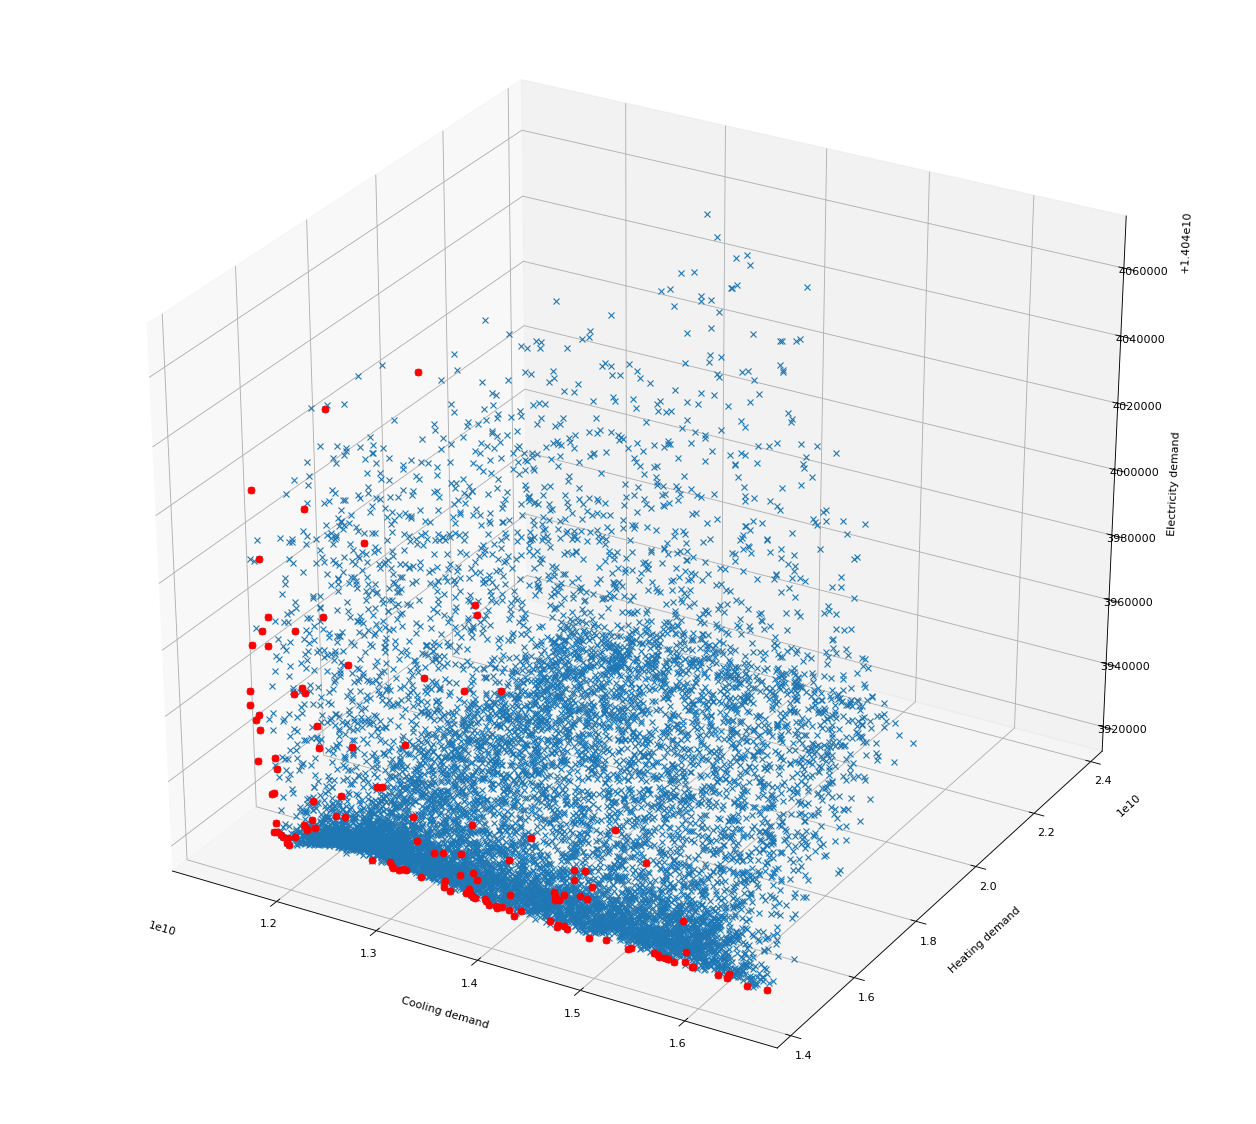

In [38]:
# Plotting results
plt.figure(figsize=(20, 18), dpi=80)
ax = plt.axes(projection='3d')

optres = final_results.loc[final_results["pareto-optimal"] == True, :]  # Get only the optimal results

df = pd.DataFrame(optres, columns=features + objectives)

ax.plot3D(final_results["DistrictCooling:Facility"].values, final_results["DistrictHeating:Facility"].values, final_results["Electricity:Facility"].values, "x")  # Plot all results in the background as blue crosses
ax.plot3D(optres["DistrictCooling:Facility"].values, optres["DistrictHeating:Facility"].values, optres["Electricity:Facility"].values, "ro")  # Plot optimal results in red

# Setting labels for each axis with increased spacing between labels and ticks
ax.set_xlabel("Cooling demand", labelpad=15)
ax.set_ylabel("Heating demand", labelpad=15)
ax.set_zlabel("Electricity demand", labelpad=15)

df['Total'] = df['Electricity:Facility'] + df['DistrictHeating:Facility'] + df['DistrictCooling:Facility']
df['Dist'] = df.apply(lambda row: np.sqrt(pow(row["DistrictCooling:Facility"], 2) + pow(row["DistrictHeating:Facility"], 2) + pow(row["Electricity:Facility"], 2)), axis=1)

df[df.Dist == df.Dist.min()]

In [42]:
optres

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,violation,pareto-optimal,Q
834,0.038151,142.433731,18.036519,5.970285,1.404394e+10,2.096769e+10,1.153070e+10,0,True,4.082660e+08
1339,0.056049,81.838793,18.034990,5.740878,1.404402e+10,2.000718e+10,1.131567e+10,0,True,3.979549e+08
2773,0.102960,183.425314,18.984952,5.936397,1.404392e+10,1.823376e+10,1.171553e+10,0,True,3.859053e+08
3309,0.121809,185.517419,18.916662,1.770684,1.404392e+10,1.783965e+10,1.397870e+10,0,True,4.023006e+08
3596,0.131678,140.825862,19.255135,5.958408,1.404393e+10,1.709815e+10,1.156266e+10,0,True,3.746029e+08
...,...,...,...,...,...,...,...,...,...,...
9979,0.349294,236.578734,19.685376,2.395559,1.404392e+10,1.437634e+10,1.385054e+10,0,True,3.707965e+08
9989,0.349551,230.283747,27.648159,3.931603,1.404392e+10,1.461996e+10,1.361418e+10,0,True,3.708601e+08
9990,0.349566,109.043392,25.666138,5.706171,1.404395e+10,1.443484e+10,1.217112e+10,0,True,3.565782e+08
9991,0.349587,213.853965,26.915791,3.464899,1.404392e+10,1.459394e+10,1.385788e+10,0,True,3.727696e+08


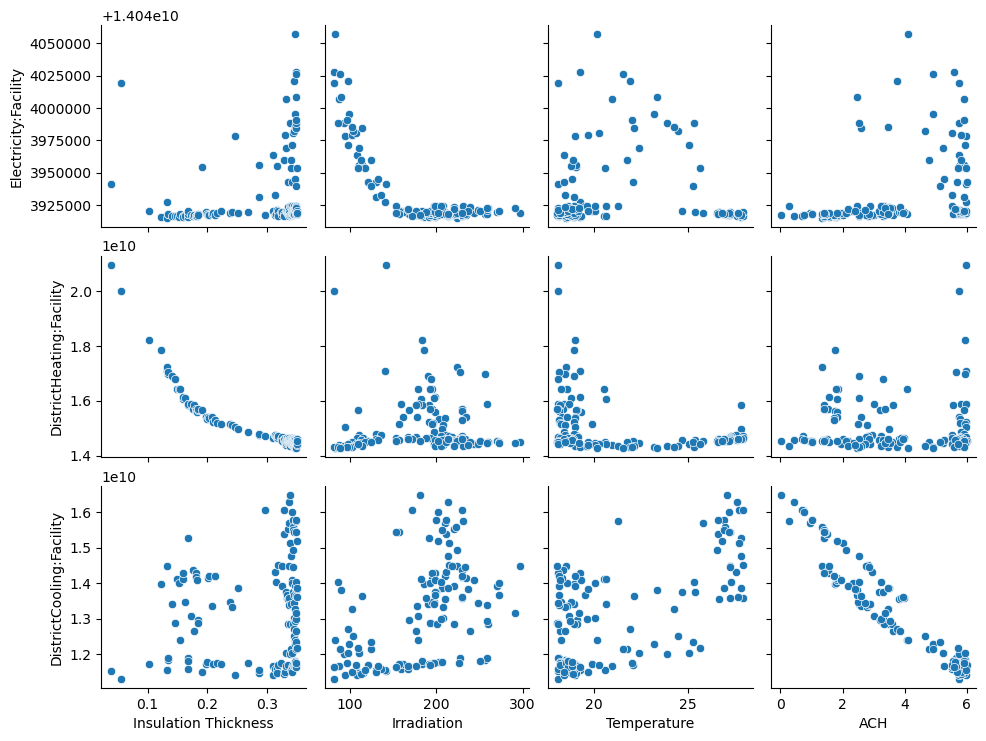

In [44]:
_=pairplot(optres,x_vars=samples.columns, y_vars=objectives, kind="scatter")
plt.savefig('all_final.png', format='png', dpi=600)

In [45]:
corr=optres.corr()

In [46]:
unuseful = ['violation','pareto-optimal']

In [47]:
corr.drop(objectives + unuseful, axis = 1, inplace = True)
corr.drop(features + unuseful, axis = 0 ,inplace = True)
corr

,Insulation Thickness,Irradiation,Temperature,ACH,Q
Electricity:Facility,0.230790,-0.791754,-0.029422,0.391805,-0.445981
DistrictHeating:Facility,-0.898507,0.004873,-0.343752,0.098779,0.507108
DistrictCooling:Facility,0.170792,0.481243,0.616101,-0.953890,0.765788


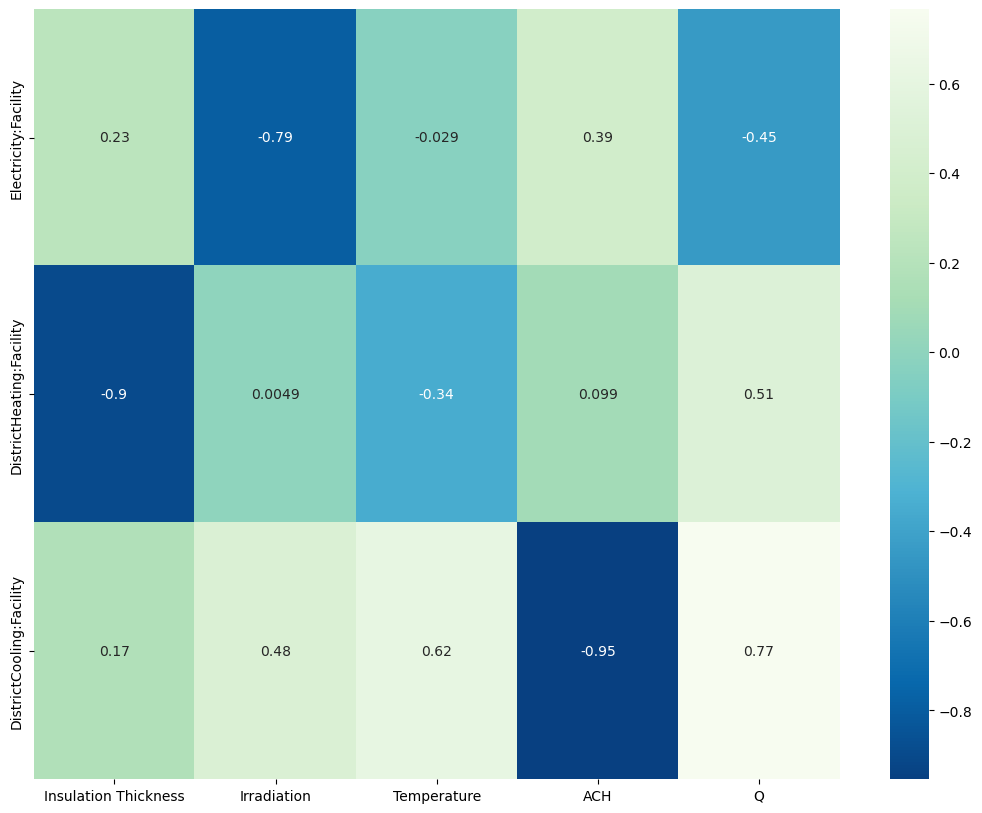

In [49]:
plt.figure(figsize = (13,10))
_ = heatmap(corr,annot=True, cmap='GnBu_r')
plt.savefig('outputs_corr_final.png', format='png', dpi=600, bbox_inches='tight')

In [50]:
df['Total'] = df['Electricity:Facility'] + df['DistrictHeating:Facility'] + df['DistrictCooling:Facility']
df['Dist'] = df.apply(lambda row : np.sqrt(pow(row["DistrictCooling:Facility"],2) + pow(row["DistrictHeating:Facility"],2) + pow(row["Electricity:Facility"],2)),axis=1)

df[df.Dist == df.Dist.min()]

,Insulation Thickness,Irradiation,Temperature,ACH,Electricity:Facility,DistrictHeating:Facility,DistrictCooling:Facility,Total,Dist
9924,0.347823,81.923858,19.256269,5.597644,1.404403e+10,1.430754e+10,1.163074e+10,3.998231e+10,2.317789e+10


In [58]:
# Insert the new columns into df before the 'Dist' column
df.insert(df.columns.get_loc('Dist'), 'violation', optres['violation'])
df.insert(df.columns.get_loc('Dist'), 'pareto-optimal', optres['pareto-optimal'])
df.insert(df.columns.get_loc('Dist'), 'Q', optres['Q'])

In [59]:
optimal_params=df.loc[df.Dist == df.Dist.min(),features].to_dict('records')[0]
optimal_params

{'Insulation Thickness': 0.3478226671106654,
 'Irradiation': 81.92385779804181,
 'Temperature': 19.25626870877872,
 'ACH': 5.597644004360683,
 'violation': 0,
 'pareto-optimal': True,
 'Q': 350722042.2737186}

In [61]:
insulation.set(building,optimal_params['Insulation Thickness'])
shading_solar.set(building,optimal_params['Irradiation'])
shading_temp.set(building,optimal_params['Temperature'])
ventilation.set(building,optimal_params['ACH'])
#selection of windows parameters
win_type = 'double_glazing'
for fenestration in building.idfobjects["FenestrationSurface:Detailed"]:
     if fenestration.obj[2] == "Window":
        win_sel = FieldSelector(class_name ='FenestrationSurface:Detailed', 
                            object_name = fenestration.Name, 
                            field_name='Construction Name' )
        win_sel.set(building,win_type)

In [62]:
building.saveas('double_optimal.idf')